In [1]:
import tifffile
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
import os
from skimage.measure import regionprops
import sys
import datasetmaker as dm
from scipy.signal import hilbert

# Get the parent directory
parent_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))

# Add the parent directory to sys.path
sys.path.append(parent_dir)
from onlypores import onlypores as op
from UTXCTregister import UTXCTregister as reg

# set ggplot style
plt.style.use("ggplot")

import pywt

In [2]:
def read_sequence(folder_path):
    """
    Read a sequence of TIFF files in a folder as a 3D volume.

    Args:
    folder_path (str): Path to the folder containing TIFF files.

    Returns:
    numpy.ndarray: A 3D array where each slice corresponds to a TIFF file.
    """

    # List and sort the TIFF files
    tiff_files = sorted(
        [
            os.path.join(folder_path, f)
            for f in os.listdir(folder_path)
            if (f.endswith(".tiff") or f.endswith(".tif"))
        ]
    )

    tiff_sequence = tifffile.TiffSequence(tiff_files)

    # Get the total number of TIFF files
    total_files = len(tiff_files)

    # Read each TIFF file and update progress
    volume = []
    with tqdm(total=total_files, desc="Progress") as pbar:
        for i, file_path in enumerate(tiff_files):
            slice_data = tifffile.imread(file_path)
            volume.append(slice_data)

            # Update progress
            pbar.update(1)

    return np.array(volume)


def to_matrix(string):
    matrix1 = float(string[2:17])

    matrix2 = float(string[17:33])

    matrix3 = float(string[33:49])

    matrix4 = float(string[53:68])

    matrix5 = float(string[68:84])

    matrix6 = float(string[84:100])

    matrix7 = float(string[105:121])

    matrix8 = float(string[121:137])

    matrix9 = float(string[137:151])

    matrix = np.array(
        [
            [matrix1, matrix2, matrix3],
            [matrix4, matrix5, matrix6],
            [matrix7, matrix8, matrix9],
        ]
    )

    return matrix


def hillbert_transform(volume):
    """
    This function applies the Hilbert transform to a 3D volume.

    Parameters:
    volume (numpy.ndarray): 3D array representing the volume of an image.

    Returns:
    numpy.ndarray: Amplitude envelope of the Hilbert transform.
    """

    volume = volume.copy()

    volume = volume.astype(np.int16)

    volume = volume - 128

    data_hilbert = hilbert(volume, axis=-1)
    amplitude_envelope = np.abs(data_hilbert).astype(np.uint8)

    return amplitude_envelope


def dwt(signal):
    """
    Perform Discrete Wavelet Transform (DWT) using db8 wavelet.

    Parameters:
        signal (numpy.ndarray): Input signal as a 1D numpy array.

    Returns:
        coeffs (list): Coefficients from the DWT.
    """

    signal = signal.copy()

    signal = signal.astype(np.int16) - 128

    # Perform DWT using db8 wavelet with level 5
    # coeffs = pywt.wavedec(signal, wavelet='db8', level=5)

    # Perform Wavelet Packet Transform (WPT) using Daubechies wavelet of order 5 ('db5')
    wavelet_name = "db5"
    wp = pywt.WaveletPacket(
        data=signal, wavelet=wavelet_name, mode="symmetric", maxlevel=4
    )

    # Get wavelet packet coefficients for level 4
    nodes = wp.get_level(
        4, order="natural"
    )  # Decompose to level 4, producing 16 subspaces
    coeffs = [node.data for node in nodes]

    return coeffs

# Load import

In [3]:
database = pd.read_csv(
    r"\\192.168.10.106\imdea\DataDriven_UT_AlbertoVicente\11_database\Database.csv"
)

database = database.replace({np.nan: None})

In [4]:
ids = database["Id"]

rfs_og = database["UT"]

rfs_lente_og = database["UT lente"]

registration_parameters = database["Registration Parameters"]

registration_parameters_lente = database["Registration Parameters lente"]

frontals = database["Frontal 90 Right"]

In [5]:
idx = 0
print(ids[idx])
print("Loading xct")
# get onlypores
xct = tifffile.imread(frontals[idx])
xct = np.swapaxes(xct, 0, 1)
xct = np.swapaxes(xct, 1, 2)
print("Loading rf")
rf = tifffile.imread(rfs_og[idx])
rf = np.swapaxes(rf, 0, 1)
rf = np.swapaxes(rf, 1, 2)
print("Aplying registration")
parameters = to_matrix(registration_parameters[idx])
xct = reg.apply_registration(rf, xct, parameters)
rf = np.swapaxes(rf, 1, 2)
rf = np.swapaxes(rf, 0, 1)
xct = np.swapaxes(xct, 1, 2)
xct = np.swapaxes(xct, 0, 1)
print("Generating onlypores")
onlypores, mask, _ = op.onlypores_parallel(xct)
print("Onlypores generated")

1_26
Loading xct
Loading rf
Aplying registration
Applying transformation
Transformation applied
Generating onlypores
masking
computing otsu
thresholding with value:  108
Onlypores generated


# pre calculations

In [32]:
ut_patch_size = 3
ut_step_size = 1
xct_resolution = 0.025
ut_resolution = 1

In [56]:
onlypores_cropped, mask_cropped, ut_rf_cropped = dm.preprocess(
    onlypores, mask, rf, xct_resolution, ut_resolution
)

# Pores distribution through layers

Vamos a ver como se distribuye la porosidad en las capas, para ver en que zona del espesor se concentra mas

In [34]:
layer_thickness = 0.508  # mm

layer_thickness = int(np.round(layer_thickness / 0.025))

indices = np.where(mask_cropped == 1)[0]

frontwall = indices[0]

backwall = indices[-1]

print(frontwall, backwall)

64 299


In [35]:
edges = [frontwall]

while True:
    edge = edges[-1]

    if edge + layer_thickness > backwall:
        break

    edges.append(edge + layer_thickness)

print(edges)

[64, 84, 104, 124, 144, 164, 184, 204, 224, 244, 264, 284]


In [36]:
# divide the onlypores volume in layers

layers = []

mask_layers = []

for i in tqdm(range(len(edges) - 1)):
    layers.append(onlypores_cropped[edges[i] : edges[i + 1]])

    mask_layers.append(mask_cropped[edges[i] : edges[i + 1]])

# compute the sum of onlypores for each layer

sum_onlypores_layers = []

for i in tqdm(range(len(layers) - 1)):
    sum_onlypores_layers.append(
        np.sum(layers[i : i + 1]) / np.sum(mask_layers[i : i + 1])
    )

sum_onlypores_layers = np.array(sum_onlypores_layers)

sum_onlypores_layers.shape

100%|██████████| 10/10 [00:30<00:00,  3.08s/it]


(10,)

Text(0.5, 1.0, 'Porosity for each layer')

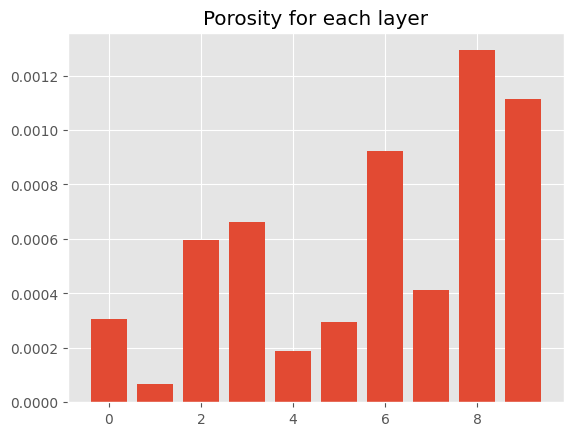

In [37]:
plt.bar(np.arange(len(sum_onlypores_layers)), sum_onlypores_layers)
plt.title("Porosity for each layer")

In [57]:
onlypores_cropped = onlypores_cropped[: edges[-3]]

# Patching

In [58]:
patches_onlypores, patches_mask, patches_ut = dm.patch(
    onlypores_cropped,
    mask_cropped,
    ut_rf_cropped,
    ut_patch_size,
    ut_step_size,
    xct_resolution,
    ut_resolution,
)

print(patches_ut.shape, patches_onlypores.shape, patches_mask.shape)

(2701, 505, 3, 3) (2701, 244, 40, 40) (2701, 308, 40, 40)


# Pore size 

Tenemos otro problemon, no estoy seguro de que tamaños de poros estamos considerando.

Es decir, nuestro transductor de 5 MHZ emite señales de ultrasonidos que interactuan con objetos de tamaño hasta 0.3 mm(12 pixeles en nuestro caso) en el plano (x,y).

En z el minimo es 0.297mm(38 pixeles).

Tenemos que analizar los tamaños que realmente tenemos para ver si estamos intentando ver lo invisible.

## Volumetric pore size

Vamos a hacerlo ahora en 3D para tener en cuenta la distancia entre los poros.

Es decir, no podemos agrupar 2 poros que estan cerca en (x,y) pero a tomar por culo en z

Pero surge un problema ahora, como determinamos si es grande un poro o no. Es decir, tenemos un problema aqui, un poro de area uno en el plano (x,y) pero con 200 de longitud en z no se ve en UT. Asique lo que realmente necesitamos es agrupar 3D, pero luego calcular para cada particula el eje largo en el plano (x,y).

In [59]:
from skimage.measure import label
import scipy.ndimage
import numpy as np
import pandas as pd
from joblib import Parallel, delayed
from tqdm import tqdm


# Function to process each slice
def process_slice(i, patches_onlypores):
    dilated_image = scipy.ndimage.binary_dilation(patches_onlypores[i], iterations=2)
    labeled_image = label(dilated_image)
    indexes = np.where(patches_onlypores[i] == 0)
    labeled_image[indexes] = 0

    properties = []  # To store properties for this slice

    # Loop over the labels and get the needed properties
    for l in np.unique(labeled_image):
        if l == 0 and (np.unique(label) != 1):
            continue

        # Get the mask of the label
        indexes = np.where(labeled_image == l)
        mask = np.zeros_like(labeled_image)
        mask[indexes] = 1

        xyproj = np.max(mask, axis=0)
        xzproj = np.max(mask, axis=1)

        # Find the indices of all non-zero elements
        non_zero_indices = np.nonzero(xzproj)

        if (
            non_zero_indices[0].size == 0
        ):  # Handle case where there are no non-zero elements
            continue

        # Extract the row indices
        row_indices = non_zero_indices[0]

        # Determine the first and last row with a labeled pixel
        first_row = np.min(row_indices)
        last_row = np.max(row_indices)

        # Get properties in each projection
        xyprops = regionprops(xyproj)
        xzprops = [{"Z Length": last_row - first_row}]

        for xy, xz in zip(xyprops, xzprops):
            if l == 0:
                l = 1
            properties.append(
                {
                    "Image Index": i,
                    "Label": l,
                    "xy Major Axis Length": xy.major_axis_length,
                    "xy Minor Axis Length": xy.minor_axis_length,
                    "Z Length": xz["Z Length"],
                    "Solidity": xy.solidity,
                }
            )

        if l == 0:
            labeled_image[labeled_image == 0] = 1

    return labeled_image, properties


# Assuming proj_onlypores is already loaded as a numpy array
# proj_onlypores = ...

# Parallel processing of slices
results = Parallel(n_jobs=-1, backend="loky")(
    delayed(process_slice)(i, patches_onlypores)
    for i in tqdm(range(patches_onlypores.shape[0]))
)

# Collect results
labeled_volume_onlypores, properties_list = zip(*results)

labeled_volume_onlypores = np.array(labeled_volume_onlypores)

# Convert the properties list to a pandas DataFrame
properties_df_3D = pd.DataFrame(
    [item for sublist in properties_list for item in sublist]
)

# Display the DataFrame
print(properties_df_3D.head())

  0%|          | 0/2701 [00:00<?, ?it/s]

100%|██████████| 2701/2701 [00:20<00:00, 131.85it/s]


   Image Index  Label  xy Major Axis Length  xy Minor Axis Length  Z Length  \
0            8      1              0.000000              0.000000         1   
1            8      2             28.499821              9.129655        10   
2            8      3             10.162671              3.162919         1   
3            9      1              7.988251              3.167649         1   
4            9      2              0.000000              0.000000         0   

   Solidity  
0  1.000000  
1  0.595238  
2  0.750000  
3  0.650000  
4  1.000000  


# Areafrac & Volfrac calculation

In [60]:
# compute the sum of onlypores and mask
sum_onlypores_patches = np.sum(patches_onlypores, axis=1)
sum_mask_patches = np.sum(patches_mask, axis=1)

proj_onlypores = np.max(patches_onlypores, axis=1)
proj_mask = np.max(patches_mask, axis=1)

#######volfrac for patch vs volfrac dataset

sum_onlypores = np.sum(sum_onlypores_patches, axis=(1, 2))
sum_mask = np.sum(sum_mask_patches, axis=(1, 2))

# the points that are zero in the mask are not material, so we set them to -1 in volfrac to know that they are not material

zero_indices = np.where(sum_mask == 0)

volfrac = sum_onlypores / (sum_mask + 1e-6)

volfrac[zero_indices] = -1

# areafrac
sum_onlypores_area = np.sum(proj_onlypores, axis=(1, 2)).astype(np.int16)
sum_mask_area = np.sum(proj_mask, axis=(1, 2)).astype(np.int16)

areafrac = sum_onlypores_area / (sum_mask_area + 1e-6)

zero_indices = np.where(sum_mask_area == 0)

areafrac[zero_indices] = -1

# Material percentage cleaning

Vamos a limpiar segun el porcentaje de material.

Porque hay parches que casi ni tienen material y estamos tomandolos como representativos y no esta bien eso, porque no tenemos verdadero control de
como de pororsas son esas zonas.

Asique vamos a explorar los parches como poco material para settear un threshold y descartarlos junto con los que tienen 0

(array([4.500e+01, 2.000e+00, 4.000e+00, 5.000e+00, 5.000e+00, 8.000e+00,
        4.000e+00, 4.000e+00, 9.600e+01, 2.528e+03]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

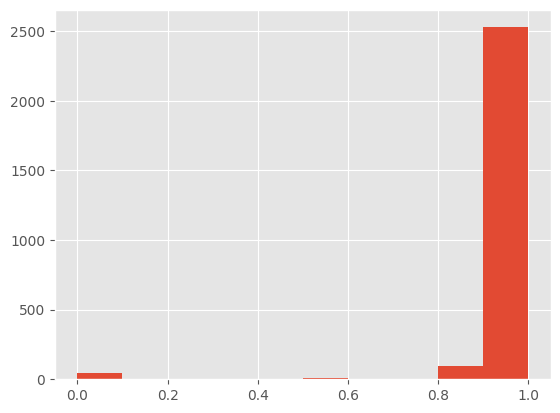

In [61]:
# material percentage
full_material = np.max(sum_mask)

mat_percentage = sum_mask / full_material

# histogram of material percentage
plt.hist(mat_percentage, bins=10)

Indexes 77
Index 758
Material percentage 0.026666433619398855
Volfrac 0.0
Areafrac 0.0


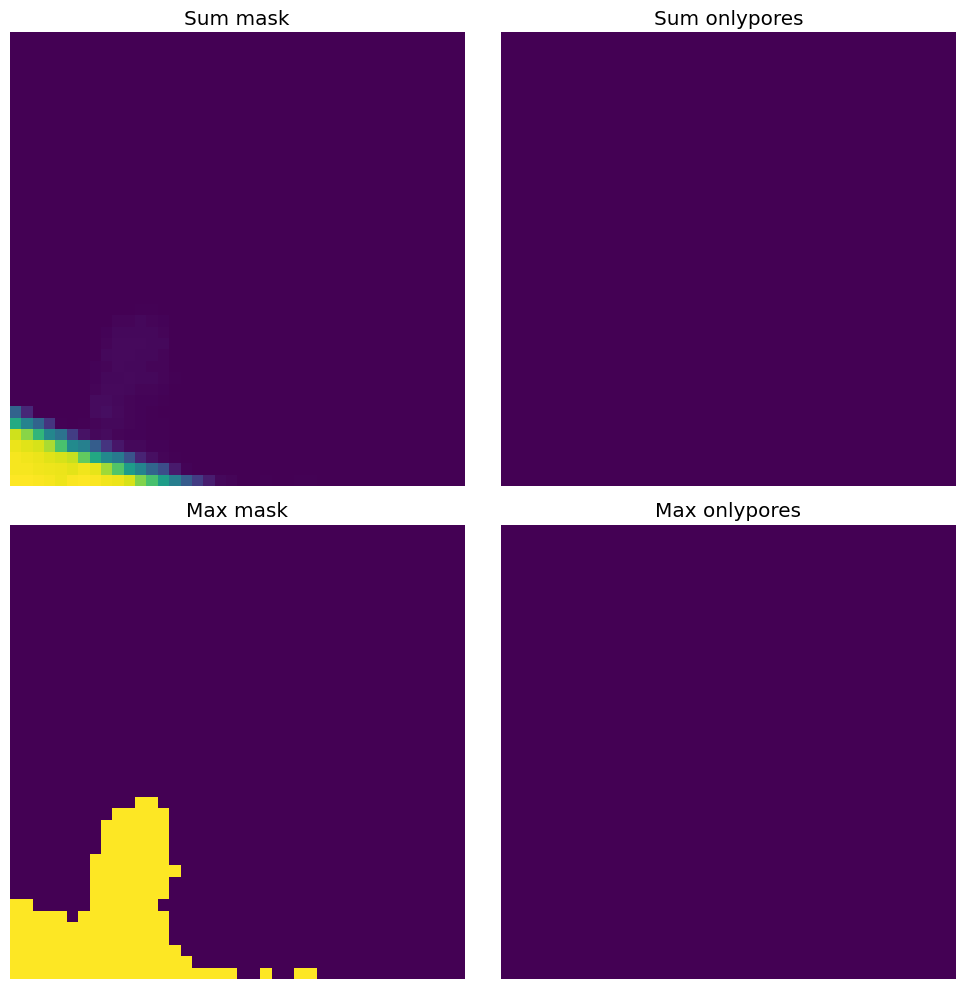

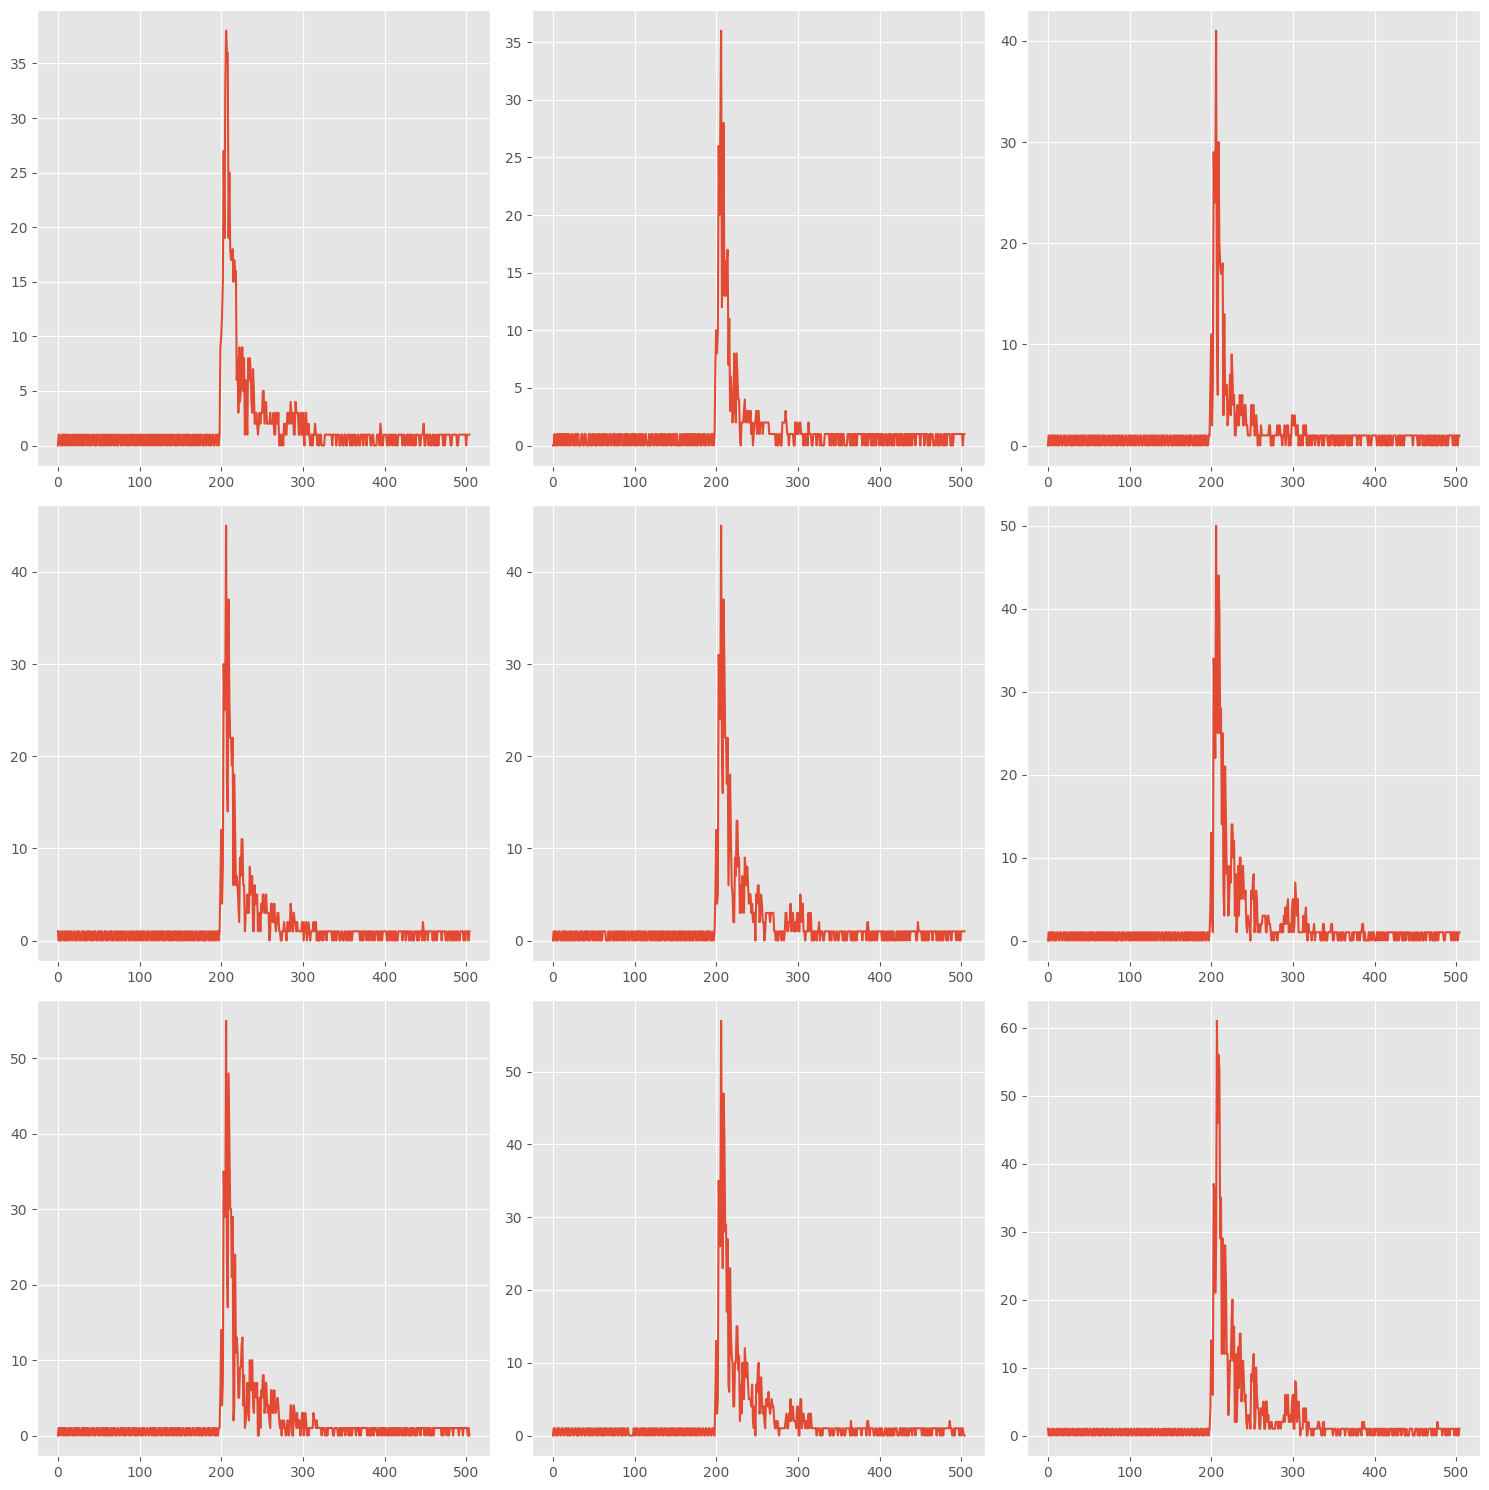

In [62]:
indexes = np.where(mat_percentage < 0.8)[0]

print("Indexes", len(indexes))

# select a random index
idx = np.random.choice(indexes)

print("Index", idx)

print("Material percentage", mat_percentage[idx])

print("Volfrac", volfrac[idx])

print("Areafrac", areafrac[idx])

# Load images
img1 = sum_mask_patches[idx]
img2 = sum_onlypores_patches[idx]
img3 = proj_mask[idx]
img4 = proj_onlypores[idx]

# Create a figure with four subplots arranged in a 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

# Display the first image
axes[0, 0].imshow(img1)
axes[0, 0].axis("off")  # Hide axes
axes[0, 0].set_title("Sum mask")

# Display the second image
axes[0, 1].imshow(img2)
axes[0, 1].axis("off")  # Hide axes
axes[0, 1].set_title("Sum onlypores")

# Display the third image
axes[1, 0].imshow(img3)
axes[1, 0].axis("off")  # Hide axes
axes[1, 0].set_title("Max mask")

# Display the fourth image
axes[1, 1].imshow(img4)
axes[1, 1].axis("off")  # Hide axes
axes[1, 1].set_title("Max onlypores")

# Show the figure
plt.tight_layout()
plt.show()

# Assuming patches is a numpy array with shape (505, 3, 3)
patches = patches_ut[idx].reshape((-1, 9))  # Replace this with your actual data

patches = hillbert_transform(patches)

# Create a figure and a 9x9 grid of subplots
fig, axes = plt.subplots(3, 3, figsize=(15, 15))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot each patch in the corresponding subplot
for i in range(9):  # Ensure we don't exceed 81 patches
    ax = axes[i]
    patch = patches[:, i]
    ax.plot(patch)

# Adjust layout
plt.tight_layout()
plt.show()

Efectivamente vamos a cribar en 80% de material.

(array([  3.,   1.,   0.,   6., 140., 392., 718., 807., 482.,  75.]),
 array([0.80795449, 0.82715904, 0.84636359, 0.86556814, 0.88477269,
        0.90397724, 0.92318179, 0.94238635, 0.9615909 , 0.98079545,
        1.        ]),
 <BarContainer object of 10 artists>)

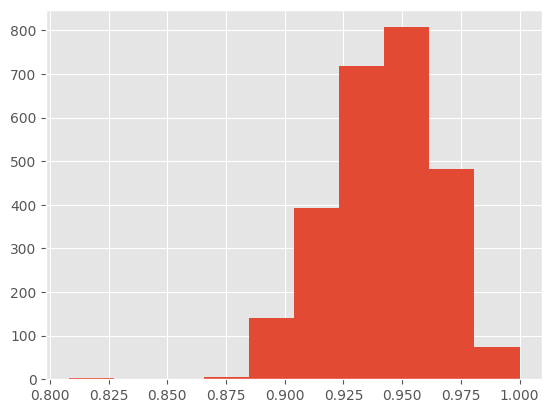

In [63]:
mat_indexes = np.where(mat_percentage < 0.8)[0]

volfrac[mat_indexes] = -1

areafrac[mat_indexes] = -1

# histogram of material percentage
plt.hist(mat_percentage[volfrac != -1], bins=10)

# Exploration

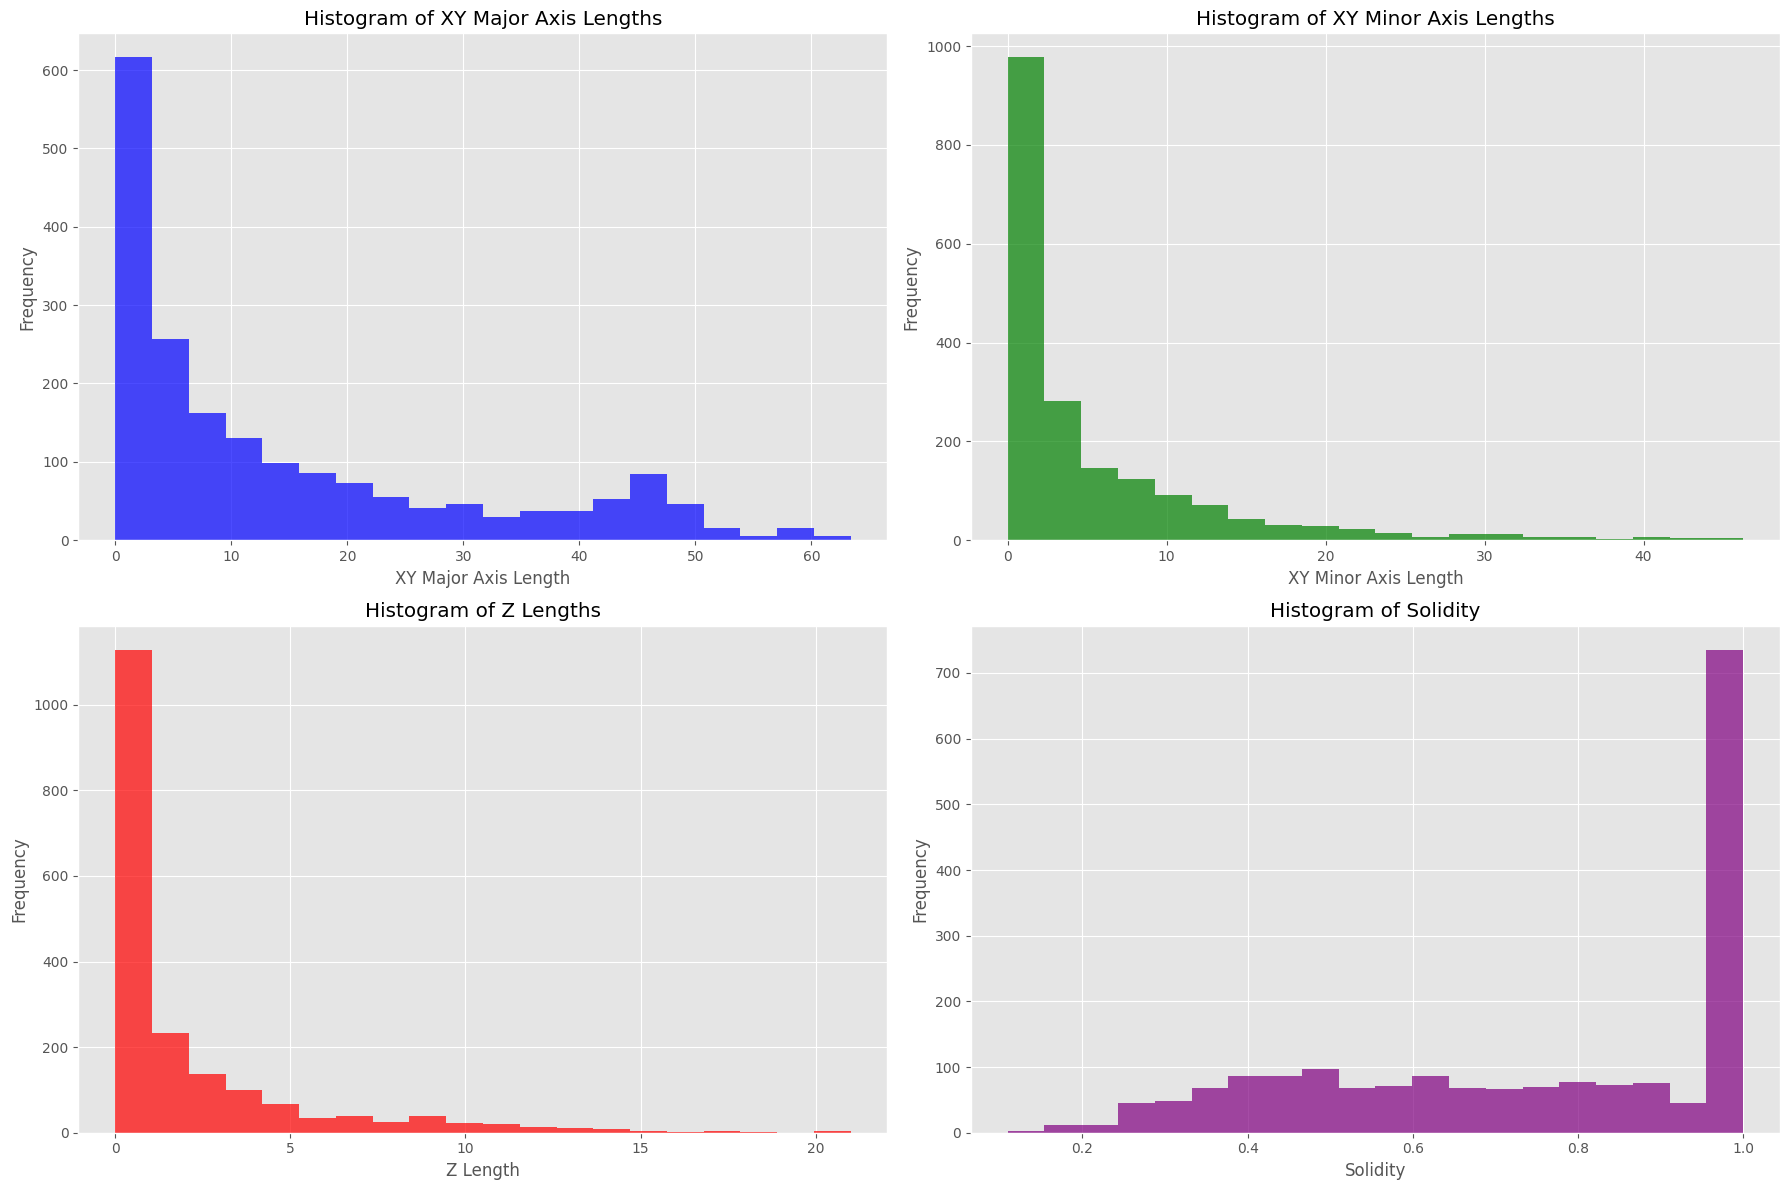

In [65]:
# inspect major axis lengths
# Get the major axis lengths of the labeled regions
xy_maj = properties_df_3D["xy Major Axis Length"].values
xy_min = properties_df_3D["xy Minor Axis Length"].values
z_lengths = properties_df_3D["Z Length"].values
solidty = properties_df_3D["Solidity"].values

fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Plot histogram for XY major axis lengths
axes[0, 0].hist(xy_maj, bins=20, color="blue", alpha=0.7)
axes[0, 0].set_title("Histogram of XY Major Axis Lengths")
axes[0, 0].set_xlabel("XY Major Axis Length")
axes[0, 0].set_ylabel("Frequency")

# Plot histogram for XY minor axis lengths
axes[0, 1].hist(xy_min, bins=20, color="green", alpha=0.7)
axes[0, 1].set_title("Histogram of XY Minor Axis Lengths")
axes[0, 1].set_xlabel("XY Minor Axis Length")
axes[0, 1].set_ylabel("Frequency")

# Plot histogram for Z lengths
axes[1, 0].hist(z_lengths, bins=20, color="red", alpha=0.7)
axes[1, 0].set_title("Histogram of Z Lengths")
axes[1, 0].set_xlabel("Z Length")
axes[1, 0].set_ylabel("Frequency")

# Plot histogram for solidity
axes[1, 1].hist(solidty, bins=20, color="purple", alpha=0.7)
axes[1, 1].set_title("Histogram of Solidity")
axes[1, 1].set_xlabel("Solidity")
axes[1, 1].set_ylabel("Frequency")

plt.tight_layout()
plt.show()

Indexes 1846


100%|██████████| 1846/1846 [00:03<00:00, 524.29it/s]


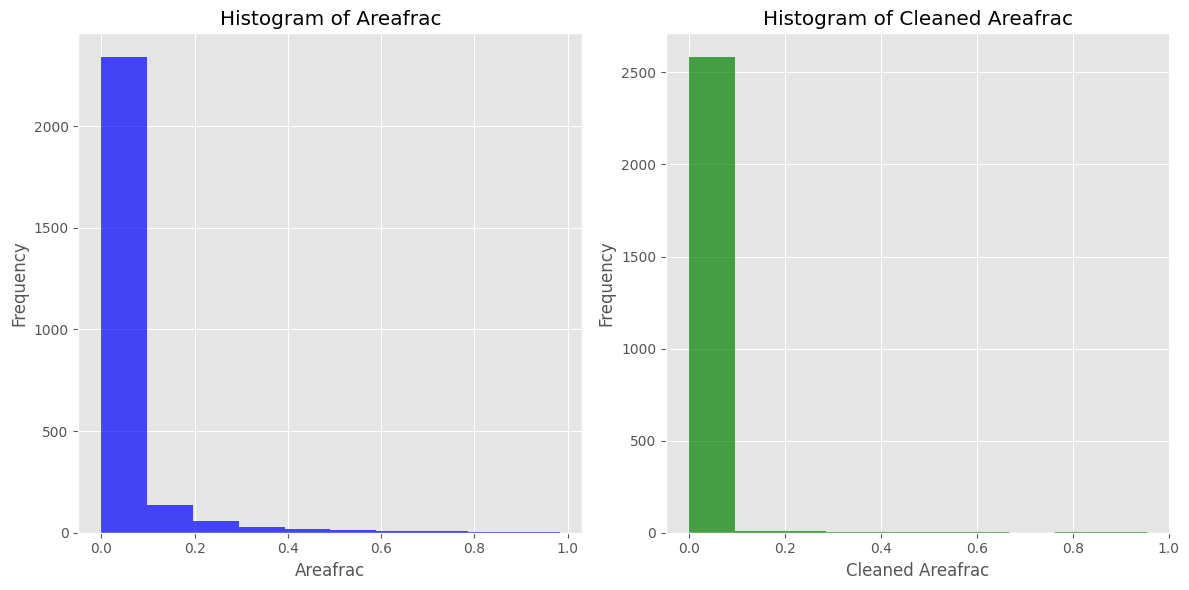

In [93]:
minor_axis_lengths = properties_df_3D["Z Length"].values

solidity = properties_df_3D["Solidity"].values

indexes = np.where(minor_axis_lengths < 12)[0]

# indexes2 = np.where(solidity < 0.5)[0]

# indexes = np.union1d(indexes, indexes2)

print("Indexes", len(indexes))

cleaned_labeled_patches_onlypores = np.copy(labeled_volume_onlypores)

for i in tqdm(indexes):
    row = properties_df_3D.iloc[i]
    img_idx = int(row["Image Index"])
    delete_indexes = np.where(labeled_volume_onlypores[img_idx] == row["Label"])
    cleaned_labeled_patches_onlypores[img_idx][delete_indexes] = 0

cleaned_patches_onlypores = cleaned_labeled_patches_onlypores > 0

cleaned_patches_onlypores_proj = np.max(cleaned_patches_onlypores, axis=1)

# areafrac
sum_cleaned_onlypores_area = np.sum(cleaned_patches_onlypores_proj, axis=(1, 2)).astype(
    np.int16
)

cleaned_areafrac = sum_cleaned_onlypores_area / (sum_mask_area + 1e-6)

zero_indices = np.where(sum_mask_area == 0)

cleaned_areafrac[zero_indices] = -1

cleaned_areafrac[mat_indexes] = -1

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot histogram for areafrac
axes[0].hist(areafrac[areafrac != -1], bins=10, color="blue", alpha=0.7)
axes[0].set_title("Histogram of Areafrac")
axes[0].set_xlabel("Areafrac")
axes[0].set_ylabel("Frequency")

# Plot histogram for cleaned_areafrac
axes[1].hist(
    cleaned_areafrac[cleaned_areafrac != -1], bins=10, color="green", alpha=0.7
)
axes[1].set_title("Histogram of Cleaned Areafrac")
axes[1].set_xlabel("Cleaned Areafrac")
axes[1].set_ylabel("Frequency")

plt.tight_layout()
plt.show()

274
Material percentage 0.9126946672958943
Areafrac  0.28499999982187496
Cleaned Areafrac  0.0
------------------------


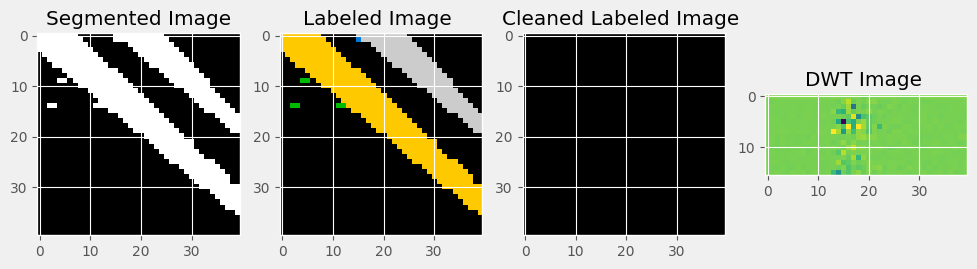

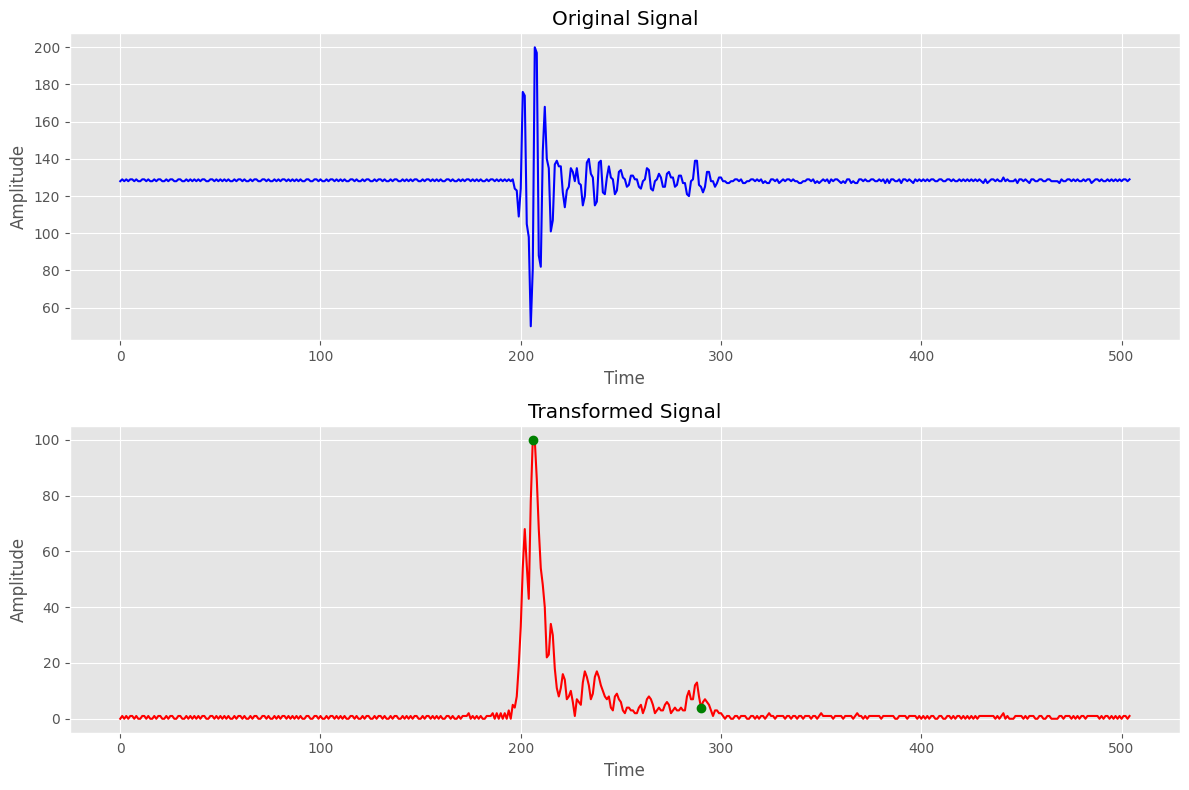

In [146]:
indexes1 = properties_df_3D[properties_df_3D["Z Length"] < 12]["Image Index"]

indexes2 = np.where((areafrac != -1))[0]

indexes = np.intersect1d(indexes1, indexes2)

# indexes = np.where((areafrac != -1))[0]

# indexes = np.where((cleaned_areafrac < 2) & (cleaned_areafrac >  0.9))[0]

idx = np.random.choice(indexes)

# idx = 2421

print(idx)

print("Material percentage", mat_percentage[idx])

print("Areafrac ", areafrac[idx])

print("Cleaned Areafrac ", cleaned_areafrac[idx])

print("------------------------")

segmented_image = proj_onlypores[idx]

# Label the segmented image
labeled_image = labeled_volume_onlypores[idx].max(axis=0)

num_features = len(np.unique(labeled_image)) - 1

zeros = np.where(cleaned_patches_onlypores_proj[idx] == 0)

cleaned_labeled_image = labeled_image.copy()

cleaned_labeled_image[zeros] = 0

signal = patches_ut[idx, :, 1, 1].reshape((-1))

dwt_img = dwt(signal)

# Get the properties of the labeled regions
properties = properties_df_3D[properties_df_3D["Image Index"] == idx]

# Print the properties of each labeled region
# for _, prop in properties.iterrows():
#     print(f"Major Axis Length: {prop['xy Major Axis Length']}")
#     print(f"Minor Axis Length: {prop['xy Minor Axis Length']}")
#     print(f"Z Length: {prop['Z Length']}")
#     print("")

# Display the original and labeled images
fig, axes = plt.subplots(1, 4, figsize=(12, 6))
light_gray = "#f0f0f0"  # Light gray color
fig.patch.set_facecolor(light_gray)

axes[0].imshow(segmented_image, cmap="gray")
axes[0].set_title("Segmented Image")

axes[1].imshow(labeled_image, cmap="nipy_spectral")
axes[1].set_title("Labeled Image ")

axes[2].imshow(cleaned_labeled_image, cmap="nipy_spectral")
axes[2].set_title("Cleaned Labeled Image ")

axes[3].imshow(dwt_img, cmap="viridis")
axes[3].set_title("DWT Image ")

plt.show()

signal = patches_ut[idx, :, 1, 1].reshape((-1))

amp = hillbert_transform(signal)

frontwall = np.argmax(amp)

backwall = frontwall + int(np.round(5 / 0.05940588))

point1 = (frontwall, amp[frontwall])

point2 = (backwall, amp[backwall])

points = [point1, point2]

labels = labeled_volume_onlypores[idx]

xct_frontwall = np.where(patches_mask[idx] == 1)[0][0]

for l in np.unique(labels):
    if l == 0:
        continue

    point = np.where(labels == l)[0][0]

    distance = point - xct_frontwall

    distance = int(np.round((distance * 0.025) / 0.05940588))

    point = frontwall + distance

    points.append((point, amp[point]))

# Create a figure for plotting the two signals
fig, ax = plt.subplots(2, 1, figsize=(12, 8))

# Plot the original signal
ax[0].plot(signal, color="blue")
ax[0].set_title("Original Signal")
ax[0].set_xlabel("Time")
ax[0].set_ylabel("Amplitude")

# Plot the transformed signal
ax[1].plot(amp, color="red")
ax[1].set_title("Transformed Signal")
ax[1].set_xlabel("Time")
ax[1].set_ylabel("Amplitude")

colors = [
    "go",
    "go",
    "bo",
    "yo",
    "co",
    "mo",
    "ro",
    "bo",
    "yo",
    "co",
    "mo",
]  # List of colors for different points

for i, point in enumerate(points):
    color = colors[i % len(colors)]  # Cycle through colors
    ax[1].plot(
        point[0], point[1], color
    )  # Mark the points on the transformed signal plot

plt.tight_layout()
plt.show()

import plotly.graph_objects as go

labels = labeled_volume_onlypores[idx]

# Generate a meshgrid for the (z, x, y) coordinates matching your volume shape
z, x, y = np.mgrid[0 : labels.shape[0], 0:40, 0:40]

# Filter out points where the label is 0
non_zero_mask = labels != 0

# Extract the coordinates and labels of non-zero points
z_points = z[non_zero_mask]
x_points = x[non_zero_mask]
y_points = y[non_zero_mask]
label_points = labels[non_zero_mask]

# Create a 3D scatter plot using plotly
fig = go.Figure(
    data=[
        go.Scatter3d(
            x=x_points,
            y=y_points,
            z=z_points,
            mode="markers",
            marker=dict(
                size=3,
                color=label_points,
                colorscale="Viridis",
                colorbar=dict(title="Label"),
            ),
        )
    ]
)

# Set plot title and axis labels
fig.update_layout(
    title="3D Labeled Array (Non-zero Labels Only)",
    scene=dict(xaxis_title="X Axis", yaxis_title="Y Axis", zaxis_title="Z Axis"),
)

# Show the plot
fig.show()

labels = cleaned_labeled_patches_onlypores[idx]

# Filter out points where the label is 0
non_zero_mask = labels != 0

# Extract the coordinates and labels of non-zero points
z_points = z[non_zero_mask]
x_points = x[non_zero_mask]
y_points = y[non_zero_mask]
label_points = labels[non_zero_mask]

# Create a 3D scatter plot using plotly
fig = go.Figure(
    data=[
        go.Scatter3d(
            x=x_points,
            y=y_points,
            z=z_points,
            mode="markers",
            marker=dict(
                size=3,
                color=label_points,
                colorscale="Viridis",
                colorbar=dict(title="Label"),
            ),
        )
    ]
)

# Set plot title and axis labels
fig.update_layout(
    title="3D Labeled Array (Non-zero Labels Only)",
    scene=dict(xaxis_title="X Axis", yaxis_title="Y Axis", zaxis_title="Z Axis"),
)

# Show the plot
fig.show()